In [2]:
import numpy as np
from pyrho.pgrid import PGrid
from pyrho.vis.scatter import get_scatter_plot
from pymatgen.io.vasp import Chgcar
from pyrho.charge_density import ChargeDensity
#API_KEY = open('mp_api.key', 'r').read()

In [3]:
cden_MOF = ChargeDensity.from_file("/home/slaskina/CHGCAR_sum.gz")

In [4]:
cden_MOF

ChargeDensity(pgrids={'total': <pyrho.pgrid.PGrid object at 0x7fa658183c40>}, structure=Structure Summary
Lattice
    abc : 16.85 16.85 8.425
 angles : 90.0 90.0 90.0
 volume : 2392.0470625000007
      A : 16.85 0.0 0.0
      B : 0.0 16.85 0.0
      C : 0.0 0.0 8.425
    pbc : True True True
PeriodicSite: Zn (16.8495, 8.4261, 0.0894) [1.0000, 0.5001, 0.0106]
PeriodicSite: Zn (12.6377, 16.8497, 4.3017) [0.7500, 1.0000, 0.5106]
PeriodicSite: Zn (8.4245, 0.0011, 0.0894) [0.5000, 0.0001, 0.0106]
PeriodicSite: Zn (16.8498, 4.2122, 4.3010) [1.0000, 0.2500, 0.5105]
PeriodicSite: Zn (0.0003, 12.6377, 4.3032) [0.0000, 0.7500, 0.5108]
PeriodicSite: Zn (4.2123, 0.0002, 4.3026) [0.2500, 0.0000, 0.5107]
PeriodicSite: H (1.4132, 9.1823, 2.9702) [0.0839, 0.5449, 0.3525]
PeriodicSite: H (1.4133, 9.7585, 3.5467) [0.0839, 0.5791, 0.4210]
PeriodicSite: H (1.7639, 10.6634, 3.3430) [0.1047, 0.6328, 0.3968]
PeriodicSite: H (2.0519, 10.8321, 2.5982) [0.1218, 0.6429, 0.3084]
PeriodicSite: H (1.7637, 9.3864, 2

In [5]:

cden_transformed = cden_MOF.get_transformed(
    [[1, 1, 0], [1, -1, 0], [0, 0, 1]],
    grid_out=cden_MOF.grid_shape,
    up_sample=2,
)

In [6]:
data = cden_MOF.normalized_data["total"]
print(
    f"The normalized charge density data is has a range of {data.min():0.3f} --> {data.max():0.3f} e-/Ang^3"
)

The normalized charge density data is has a range of 0.000 --> 53101.355 e-/Ang^3


In [7]:
cden_MOF.structure._lattice.angles

(90.0, 90.0, 90.0)

In [9]:
import h5py

In [10]:
with h5py.File('MOF.h5', "w") as f:
    entry = f.create_group("entry")
    I = entry.create_dataset("nomalized intensity", data=cden_MOF.normalized_data['total'], dtype='f')
    I.attrs['units'] = 'nm-1'
    properties = f.create_group("properties")
    formula = properties.create_dataset('formula', data = cden_MOF.structure.formula)
    grid_shape = properties.create_dataset('grid shape', data = cden_MOF.grid_shape, dtype = 'f')
    lattice = properties.create_dataset('lattice', data = cden_MOF.lattice, dtype = 'f')
    normalization = properties.create_dataset('normalization', data = cden_MOF.normalization)
    pbc = properties.create_dataset('pbc', data = cden_MOF.structure._lattice.pbc)
    volume = properties.create_dataset('volume', data = cden_MOF.structure._lattice.volume)
    angles = properties.create_dataset('angles', data = cden_MOF.structure._lattice.angles)
    sites = f.create_group("sites")
    for i,s in enumerate(cden_MOF.structure._sites):
        group_name = 'atom_' +str(i)
        g = sites.create_group(group_name)
        g.create_dataset('species', data = s.specie.name)
        g.create_dataset('coordinates', data = s.coords, dtype = 'f')
        g.create_dataset('frac_coordinates', data = s.frac_coords, dtype = 'f')



In [11]:
trans_data = cden_transformed.normalized_data["total"]
print(
    f"The transformed normalized charge density data is has a range of {trans_data.min():0.3f} --> {trans_data.max():0.3f} e-/Ang^3"
)

The transformed normalized charge density data is has a range of 0.000 --> 53101.355 e-/Ang^3


In [7]:
trans_data.shape

(504, 504, 256)

In [8]:
trans_data.dtype

dtype('float64')

In [9]:
from SAXSsimulations import DensityData
from SAXSsimulations.plotting import *

In [10]:
MOF_sim = DensityData()
MOF_sim.set_density(trans_data)

In [11]:
MOF_sim.pin_memory()


In [12]:
MOF_sim.calculate_custom_FTI_3D_slice(device = 'cuda') 

In [13]:
MOF_sim.calculate_custom_FTI_3D(device='cuda')

In [14]:
MOF_sim.calculate_torch_FTI_3D(device='cuda')

In [15]:
MOF_sim._FTI_custom.shape


torch.Size([504, 504, 256])

In [16]:
np.log(MOF_sim._FTI_custom).min(), np.log(MOF_sim._FTI_custom).max()

(tensor(-95.5367, dtype=torch.float64), tensor(-2.1669, dtype=torch.float64))

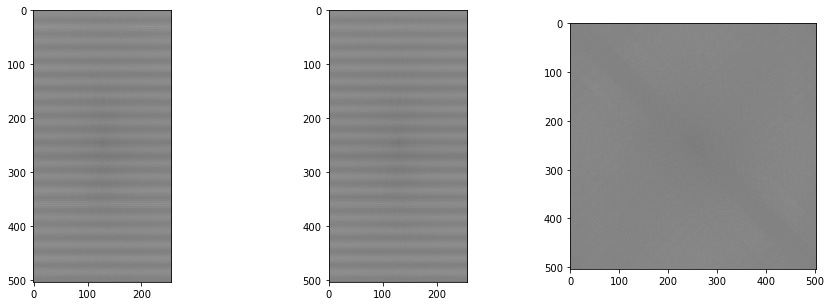

In [17]:
plt_slices_ft(MOF_sim, -100, 0)

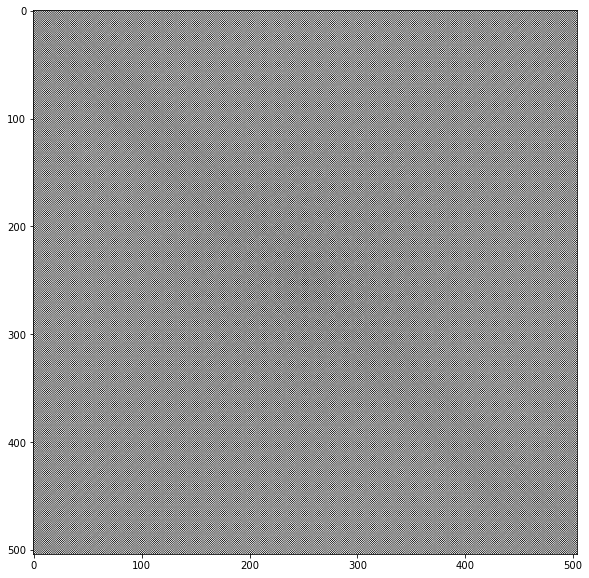

In [18]:
plt.figure(figsize = (10,10))
plt.imshow(np.log(MOF_sim._FTI_custom)[:,:,128], cmap = 'Greys')

In [1]:
import numpy as np
np.random.normal(loc = 0.1, scale = 0.05, size=100)

array([ 0.12947346,  0.2001118 ,  0.05488573,  0.08161259,  0.13636863,
        0.08548284,  0.03855996,  0.18675718,  0.15848883, -0.00135994,
        0.10659427,  0.06951365,  0.07989051,  0.11987508,  0.14582786,
        0.06377653,  0.01571863, -0.00486386,  0.08598703,  0.08711834,
        0.24025836,  0.1352869 ,  0.07140422,  0.12352377,  0.12709385,
        0.08533901,  0.05888972,  0.09518872,  0.08702521,  0.16344672,
        0.11128709,  0.15804954,  0.02204618,  0.09292551,  0.06107651,
        0.04149307,  0.02552125,  0.10792141,  0.08594399,  0.16123307,
        0.10562088,  0.11303346, -0.00593055,  0.13012469,  0.11484401,
        0.12276846,  0.11563138,  0.11877324,  0.11572286,  0.09087623,
        0.12723444,  0.03394144,  0.14792682, -0.01255697,  0.11052369,
        0.15350279,  0.00828523,  0.1126758 ,  0.11262636,  0.07735795,
        0.11803677,  0.11801317,  0.13011006,  0.04665816,  0.09596422,
        0.0544311 ,  0.0326059 ,  0.13610132,  0.13233403,  0.09